In [49]:
#import everything
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import math
import time
import keyboard
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from transformers import AdamW
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
import spacy
import pydantic
import requests
from bs4 import BeautifulSoup
from lumibot.brokers import Alpaca
from alpaca_trade_api import REST
from datetime import datetime, timedelta 
import time as Time
import pandas as pd
import scipy.stats as stats
import dask.dataframe as dd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader


In [2]:
# get data
news_data = pd.read_csv('news_data.csv')
market_data = pd.read_csv('market_data')
news_data = news_data.drop(columns=['Unnamed: 0'])
market_data = market_data.drop(columns=['Unnamed: 0'])


In [3]:
# Change the time to only have the date
market_data['timestamp'] = pd.to_datetime(market_data['timestamp'])
market_data['date'] = market_data['timestamp'].dt.date
market_data = market_data.drop(columns=['timestamp'])

market_data.head(1)

,close,high,low,trade_count,open,volume,vwap,date
0,201.0192,201.03,198.59,655489,200.49,225903783,200.656423,2016-01-04


In [4]:
# Remove the 2015th year, only keep 2016
news_data['date'] = pd.to_datetime(news_data['date'])
news_data = news_data[news_data['date'].dt.year != 2015]
news_data

,text,date
0,Tom Lee Predicts S&P 500 Surge In 2024 Despite...,2023-12-30
1,"2023's Top Dogs: Nvidia, Meta Lead S&P 500 Cha...",2023-12-29
2,"AI Revolution, Fed's Pivot Power US Stock Mark...",2023-12-29
3,Mickey Mouse Goes Public: Disney Icon Enters D...,2023-12-29
4,"Market Clubhouse Morning Memo - December 29th,...",2023-12-29
...,...,...
56962,S&P 500 Index Futures Lower.,2016-01-05
56963,MarketTalk/HammerForum Before-the-Close Imbala...,2016-01-05
56964,Traders Are Bearish For 2016.,2016-01-05
56965,Damodaran: 2015 Could've Been A Lot Worse For ...,2016-01-04


In [5]:
# for market_data: Set time as index, and sort
market_data['date'] = pd.to_datetime(market_data['date'])
market_data.set_index('date', inplace=True)
market_data.sort_index(inplace=True)
market_data.head(20)

,close,high,low,trade_count,open,volume,vwap
date,,,,,,,
2016-01-04,201.0192,201.030,198.59,655489,200.490,225903783,200.656423
2016-01-05,201.3600,201.900,200.05,418709,201.405,112719152,201.084280
2016-01-06,198.8200,200.060,197.60,548386,198.330,153948196,198.956460
2016-01-07,194.0500,197.440,193.59,796451,195.330,216191953,195.345911
2016-01-08,191.9230,195.850,191.58,754102,195.190,216105404,193.644537
2016-01-11,192.1100,193.410,189.82,701548,193.010,205368067,191.757659
2016-01-12,193.6608,194.550,191.14,635749,193.820,175844276,192.902295
2016-01-13,188.8300,194.860,188.38,812694,194.450,223632834,191.134590
2016-01-14,191.9300,193.260,187.66,824320,189.550,243821116,190.776550


In [6]:
# for news_data: Set time as index, and sort
news_data.set_index('date', inplace=True)
news_data.sort_index(inplace=True)
news_data.head(20)

,text
date,
2016-01-04,S&P 500 Index Futures Sharply Lower.
2016-01-04,Damodaran: 2015 Could've Been A Lot Worse For ...
2016-01-05,MarketTalk/HammerForum Before-the-Close Imbala...
2016-01-05,S&P 500 Index Futures Lower.
2016-01-05,MarketTalk/HammerForum Before-the-Close Imbala...
2016-01-05,Explanations are Not Predictions.
2016-01-05,What's Next For Stocks After The New Year's Da...
2016-01-05,Traders Are Bearish For 2016.
2016-01-06,Technical Take: Digging Into Gartman's Bear Ma...


In [7]:
# Market data: missing the weekends, holidays
# News data: randon missing stuff, the day that have no news

In [8]:
news_data_s = news_data.groupby(news_data.index).agg({'text': ' '.join})

# news_data_s = news_data_s.reset_index()

# # Rename the new column if needed
# news_data_s = news_data_s.rename(columns={'index': 'date'})

# market_data_s = market_data.reset_index()

# # Rename the new column if needed
# market_data_s = market_data_s.rename(columns={'index': 'date'})
market_data_s = market_data.copy()
market_data_s['text'] = ""

news_data_s.head(10)

,text
date,
2016-01-04,S&P 500 Index Futures Sharply Lower. Damodara...
2016-01-05,MarketTalk/HammerForum Before-the-Close Imbala...
2016-01-06,Technical Take: Digging Into Gartman's Bear Ma...
2016-01-07,Merrill Lynch's Michael Harnett Says DJ Transp...
2016-01-08,RBS Global Macro Team Says 'sell in May and ne...
2016-01-10,20% More Downside Coming in the S&P 500. Junk...
2016-01-11,US Says It Is Not Discussing Re-Introducing Nu...
2016-01-12,How Demographic Trends Help Explain Rising Cas...
2016-01-13,Did A Huge Commodity Fund Blow Up At 2:30PM We...


In [9]:
market_data_s

,close,high,low,trade_count,open,volume,vwap,text
date,,,,,,,,
2016-01-04,201.0192,201.03,198.59,655489,200.490,225903783,200.656423,
2016-01-05,201.3600,201.90,200.05,418709,201.405,112719152,201.084280,
2016-01-06,198.8200,200.06,197.60,548386,198.330,153948196,198.956460,
2016-01-07,194.0500,197.44,193.59,796451,195.330,216191953,195.345911,
2016-01-08,191.9230,195.85,191.58,754102,195.190,216105404,193.644537,
...,...,...,...,...,...,...,...,...
2023-12-22,473.6500,475.38,471.70,485465,473.860,67131807,473.800078,
2023-12-26,475.6500,476.58,473.99,348986,474.070,55386952,475.111253,
2023-12-27,476.5100,476.66,474.89,425538,475.440,68000811,475.770446,


In [10]:
date_range = pd.date_range(start=market_data.index.min(), end=market_data.index.max())
previous_date = None
buffer = ""
for date in date_range:

    if date not in news_data_s.index:
        continue

    buffer = buffer + news_data_s.at[date, 'text'] + " "
    
    if date in market_data_s.index:
        market_data_s.at[date, 'text'] = buffer
        buffer = ""

market_data_s

,close,high,low,trade_count,open,volume,vwap,text
date,,,,,,,,
2016-01-04,201.0192,201.03,198.59,655489,200.490,225903783,200.656423,S&P 500 Index Futures Sharply Lower. Damodara...
2016-01-05,201.3600,201.90,200.05,418709,201.405,112719152,201.084280,MarketTalk/HammerForum Before-the-Close Imbala...
2016-01-06,198.8200,200.06,197.60,548386,198.330,153948196,198.956460,Technical Take: Digging Into Gartman's Bear Ma...
2016-01-07,194.0500,197.44,193.59,796451,195.330,216191953,195.345911,Merrill Lynch's Michael Harnett Says DJ Transp...
2016-01-08,191.9230,195.85,191.58,754102,195.190,216105404,193.644537,RBS Global Macro Team Says 'sell in May and ne...
...,...,...,...,...,...,...,...,...
2023-12-22,473.6500,475.38,471.70,485465,473.860,67131807,473.800078,USA New Home Sales (MoM) For November -12.2% V...
2023-12-26,475.6500,476.58,473.99,348986,474.070,55386952,475.111253,"If You Gifted Your Family $100 In Bitcoin, Dog..."
2023-12-27,476.5100,476.66,474.89,425538,475.440,68000811,475.770446,"US Stocks Pause, Gold Rises As Dollar, Treasur..."


In [11]:
combined_data = market_data_s.drop(['high','low','trade_count','open','volume','vwap'], axis=1)
combined_data

,close,text
date,,
2016-01-04,201.0192,S&P 500 Index Futures Sharply Lower. Damodara...
2016-01-05,201.3600,MarketTalk/HammerForum Before-the-Close Imbala...
2016-01-06,198.8200,Technical Take: Digging Into Gartman's Bear Ma...
2016-01-07,194.0500,Merrill Lynch's Michael Harnett Says DJ Transp...
2016-01-08,191.9230,RBS Global Macro Team Says 'sell in May and ne...
...,...,...
2023-12-22,473.6500,USA New Home Sales (MoM) For November -12.2% V...
2023-12-26,475.6500,"If You Gifted Your Family $100 In Bitcoin, Dog..."
2023-12-27,476.5100,"US Stocks Pause, Gold Rises As Dollar, Treasur..."


In [12]:
combined_data['short_term_return'] = combined_data['close'].pct_change(periods=1).shift(-1) * 100
combined_data['long_term_return'] = combined_data['close'].pct_change(periods=7).shift(-7)* 100
combined_data.dropna(inplace=True)
#combined_data.tail(10)
combined_data

,close,text,short_term_return,long_term_return
date,,,,
2016-01-04,201.0192,S&P 500 Index Futures Sharply Lower. Damodara...,0.169536,-6.063699
2016-01-05,201.3600,MarketTalk/HammerForum Before-the-Close Imbala...,-1.261422,-4.683155
2016-01-06,198.8200,Technical Take: Digging Into Gartman's Bear Ma...,-2.399155,-5.537672
2016-01-07,194.0500,Merrill Lynch's Michael Harnett Says DJ Transp...,-1.096109,-3.086833
2016-01-08,191.9230,RBS Global Macro Team Says 'sell in May and ne...,0.097435,-3.268498
...,...,...,...,...
2023-12-13,470.5000,Fed Chair Powell Says Little Basis For Thinkin...,0.320935,0.669501
2023-12-14,472.0100,"Market Clubhouse Morning Memo - December 14th,...",-0.567785,0.771170
2023-12-15,469.3300,Atlanta Fed's Bostic Sees Two Quarter-percenta...,0.562504,1.529840


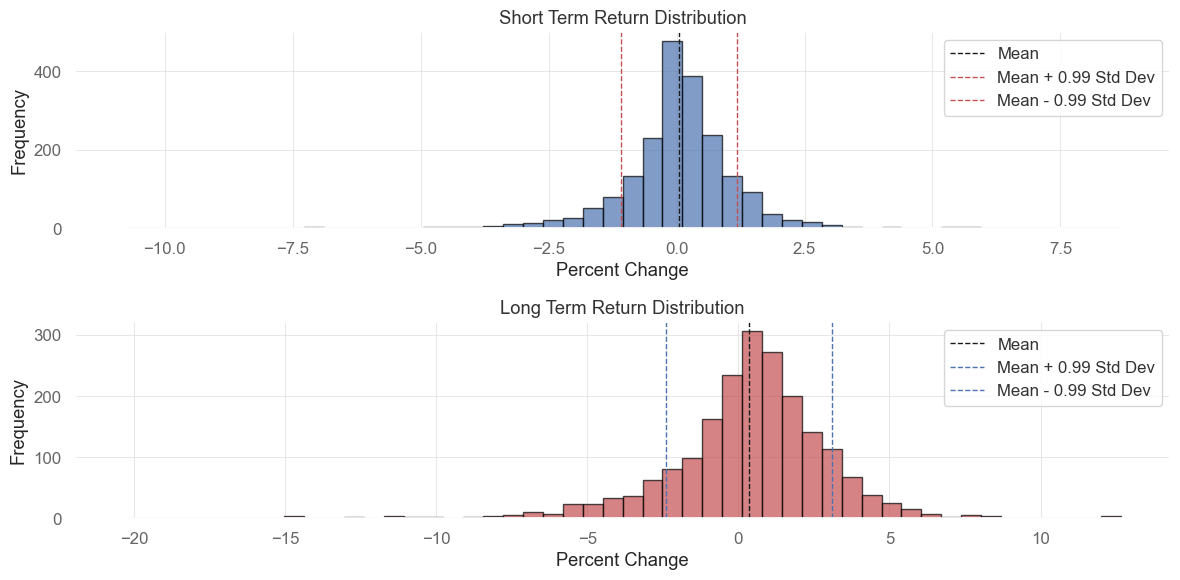

In [13]:
# Define the number of bins
num_bins = 50
coverage_percentage = 0.68
z_score = stats.norm.ppf(1 - (1 - coverage_percentage) / 2)

# Calculate min and max values for short-term and long-term returns
min_short_term = combined_data['short_term_return'].min()
max_short_term = combined_data['short_term_return'].max()
min_long_term = combined_data['long_term_return'].min()
max_long_term = combined_data['long_term_return'].max()

# Generate bin edges using numpy.linspace
bins_short_term = np.linspace(min_short_term, max_short_term, num_bins + 1)
bins_long_term = np.linspace(min_long_term, max_long_term, num_bins + 1)

# Calculate statistics
mean_short_term = combined_data['short_term_return'].mean()
std_short_term = combined_data['short_term_return'].std()
mean_long_term = combined_data['long_term_return'].mean()
std_long_term = combined_data['long_term_return'].std()

min_thresh_short_term = mean_short_term - z_score*std_short_term
max_thresh_short_term = mean_short_term + z_score*std_short_term
min_thresh_long_term = mean_long_term - z_score*std_long_term
max_thresh_long_term = mean_long_term + z_score*std_long_term

# Plotting histograms
plt.figure(figsize=(12, 6))

# Plot histogram for short-term returns
plt.subplot(2, 1, 1)
plt.hist(combined_data['short_term_return'], bins=bins_short_term, color='b', edgecolor='black', alpha=0.7)
plt.axvline(mean_short_term, color='k', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(max_thresh_short_term, color='r', linestyle='dashed', linewidth=1, label=f'Mean + {z_score:.2f} Std Dev')
plt.axvline(min_thresh_short_term, color='r', linestyle='dashed', linewidth=1, label=f'Mean - {z_score:.2f} Std Dev')
plt.title('Short Term Return Distribution')
plt.xlabel('Percent Change')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

# Plot histogram for long-term returns
plt.subplot(2, 1, 2)
plt.hist(combined_data['long_term_return'], bins=bins_long_term, color='r', edgecolor='black', alpha=0.7)
plt.axvline(mean_long_term, color='k', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(max_thresh_long_term, color='b', linestyle='dashed', linewidth=1, label=f'Mean + {z_score:.2f} Std Dev')
plt.axvline(min_thresh_long_term, color='b', linestyle='dashed', linewidth=1, label=f'Mean - {z_score:.2f} Std Dev')
plt.title('Long Term Return Distribution')
plt.xlabel('Percent Change')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [14]:
# Create labels for short term return
combined_data['label_short'] = 0
combined_data.loc[combined_data['short_term_return'] < min_thresh_short_term, 'label_short'] = -1
combined_data.loc[combined_data['short_term_return'] > max_thresh_short_term, 'label_short'] = 1

# Create labels for long term return
combined_data['label_long'] = 0
combined_data.loc[combined_data['long_term_return'] < min_thresh_long_term, 'label_long'] = -1
combined_data.loc[combined_data['long_term_return'] > max_thresh_long_term, 'label_long'] = 1
combined_data

,close,text,short_term_return,long_term_return,label_short,label_long
date,,,,,,
2016-01-04,201.0192,S&P 500 Index Futures Sharply Lower. Damodara...,0.169536,-6.063699,0,-1
2016-01-05,201.3600,MarketTalk/HammerForum Before-the-Close Imbala...,-1.261422,-4.683155,-1,-1
2016-01-06,198.8200,Technical Take: Digging Into Gartman's Bear Ma...,-2.399155,-5.537672,-1,-1
2016-01-07,194.0500,Merrill Lynch's Michael Harnett Says DJ Transp...,-1.096109,-3.086833,-1,-1
2016-01-08,191.9230,RBS Global Macro Team Says 'sell in May and ne...,0.097435,-3.268498,0,-1
...,...,...,...,...,...,...
2023-12-13,470.5000,Fed Chair Powell Says Little Basis For Thinkin...,0.320935,0.669501,0,0
2023-12-14,472.0100,"Market Clubhouse Morning Memo - December 14th,...",-0.567785,0.771170,0,0
2023-12-15,469.3300,Atlanta Fed's Bostic Sees Two Quarter-percenta...,0.562504,1.529840,0,0


In [15]:
# Count the occurrences of each label in 'label_short'
label_short_counts = combined_data['label_short'].value_counts()

# Count the occurrences of each label in 'label_long'
label_long_counts = combined_data['label_long'].value_counts()

# Print the results
print("Counts for label_short:")
print(label_short_counts)

print("\nCounts for label_long:")
print(label_long_counts)

Counts for label_short:
label_short
 0    1580
 1     213
-1     212
Name: count, dtype: int64

Counts for label_long:
label_long
 0    1543
-1     242
 1     220
Name: count, dtype: int64


In [16]:
finalized_data = combined_data.drop(['close','short_term_return', 'long_term_return'],axis=1)
finalized_data

,text,label_short,label_long
date,,,
2016-01-04,S&P 500 Index Futures Sharply Lower. Damodara...,0,-1
2016-01-05,MarketTalk/HammerForum Before-the-Close Imbala...,-1,-1
2016-01-06,Technical Take: Digging Into Gartman's Bear Ma...,-1,-1
2016-01-07,Merrill Lynch's Michael Harnett Says DJ Transp...,-1,-1
2016-01-08,RBS Global Macro Team Says 'sell in May and ne...,0,-1
...,...,...,...
2023-12-13,Fed Chair Powell Says Little Basis For Thinkin...,0,0
2023-12-14,"Market Clubhouse Morning Memo - December 14th,...",0,0
2023-12-15,Atlanta Fed's Bostic Sees Two Quarter-percenta...,0,0


In [17]:
# X = finalized_data['text']
# y_short = finalized_data['label_short']
# y_long = finalized_data['label_long']

In [20]:
%%time
def preprocess_text(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
def text_to_vector(text):
    doc = nlp(text)
    return doc.vector
nlp = spacy.load('en_core_web_md')

# Convert your pandas DataFrame to a Dask DataFrame
dask_df = dd.from_pandas(finalized_data, npartitions=24)  # Adjust npartitions based on your CPU

# Apply the preprocess_text function and join lemmas
dask_df['processed_text'] = dask_df['text'].map_partitions(lambda df: df.apply(preprocess_text))
# Ensure the processed_text column is space-separated
dask_df['processed_text'] = dask_df['processed_text'].map_partitions(lambda df: df.apply(lambda x: ' '.join(x)))
# Vectorize the processed text
dask_df['vector'] = dask_df['processed_text'].map_partitions(lambda df: df.apply(text_to_vector))

# Compute the results back into a pandas DataFrame
finalized_data = dask_df.compute()

# Convert vectors to PyTorch tensors
X_np = np.array(finalized_data['vector'].tolist())
X = torch.tensor(X_np, dtype=torch.float32)

C:\Users\User2\AppData\Local\Temp\ipykernel_7028\1784337924.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  X = torch.tensor(X.tolist(), dtype=torch.float32)


In [51]:


# Encode short_term and long_term labels
label_encoder = LabelEncoder()
y_short = torch.tensor(label_encoder.fit_transform(finalized_data['label_short']), dtype=torch.long)
y_long = torch.tensor(label_encoder.fit_transform(finalized_data['label_long']), dtype=torch.long)

# Split the data
X_train, X_test, y_short_train, y_short_test, y_long_train, y_long_test = train_test_split(
    X, y_short, y_long, test_size=0.2, random_state=42)

In [52]:
class NewsDataset(Dataset):
    def __init__(self, X, y_short, y_long):
        self.X = X
        self.y_short = y_short
        self.y_long = y_long

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y_short[idx], self.y_long[idx]

# Create Dataset instances
train_dataset = NewsDataset(X_train, y_short_train, y_long_train)
test_dataset = NewsDataset(X_test, y_short_test, y_long_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [53]:
# First Attempt
class ImpactPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ImpactPredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_short_term = nn.Linear(hidden_dim, output_dim)
        self.fc_long_term = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        short_term_output = self.fc_short_term(x)
        long_term_output = self.fc_long_term(x)
        return short_term_output, long_term_output

# Parameters
input_dim = X.shape[1]  # The size of the word vector (typically 300)
hidden_dim = 64
output_dim = 3  # 3 classes: positive, neutral, negative

# Initialize the model, loss function, and optimizer
model = ImpactPredictor(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [58]:
# Second Attempt
class DeepImpactPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DeepImpactPredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_short_term = nn.Linear(hidden_dim, output_dim)
        self.fc_long_term = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        short_term_output = self.fc_short_term(x)
        long_term_output = self.fc_long_term(x)
        return short_term_output, long_term_output

# Parameters
input_dim = X.shape[1]  # Dimension of spaCy embeddings
hidden_dim = 128
output_dim = 3  # 3 classes: positive, neutral, negative

# Initialize the model
model = DeepImpactPredictor(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [59]:
# Training loop
num_epochs = 2000
print_every = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for X_batch, y_short_batch, y_long_batch in train_loader:
        #X_batch, y_short_batch, y_long_batch = batch
        optimizer.zero_grad()
        
        # Forward pass
        short_term_output, long_term_output = model(X_batch)
        
        # Calculate loss
        loss_short_term = criterion(short_term_output, y_short_batch)
        loss_long_term = criterion(long_term_output, y_long_batch)
        loss = loss_short_term + loss_long_term
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    if (epoch+1) % print_every == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')

Epoch [10/2000], Loss: 1.2463
Epoch [20/2000], Loss: 1.1768
Epoch [30/2000], Loss: 1.1541
Epoch [40/2000], Loss: 1.0712
Epoch [50/2000], Loss: 0.9876
Epoch [60/2000], Loss: 0.9176
Epoch [70/2000], Loss: 0.8725
Epoch [80/2000], Loss: 0.7405
Epoch [90/2000], Loss: 0.6046
Epoch [100/2000], Loss: 0.6070
Epoch [110/2000], Loss: 0.4044
Epoch [120/2000], Loss: 0.4247
Epoch [130/2000], Loss: 0.2098
Epoch [140/2000], Loss: 0.2547
Epoch [150/2000], Loss: 0.1467
Epoch [160/2000], Loss: 0.4805
Epoch [170/2000], Loss: 0.0261
Epoch [180/2000], Loss: 0.0767
Epoch [190/2000], Loss: 0.0142
Epoch [200/2000], Loss: 0.3711
Epoch [210/2000], Loss: 0.0170
Epoch [220/2000], Loss: 0.0084
Epoch [230/2000], Loss: 0.0062
Epoch [240/2000], Loss: 0.0063
Epoch [250/2000], Loss: 0.0052
Epoch [260/2000], Loss: 0.0055
Epoch [270/2000], Loss: 0.0052
Epoch [280/2000], Loss: 0.0050
Epoch [290/2000], Loss: 0.0046
Epoch [300/2000], Loss: 0.0048
Epoch [310/2000], Loss: 0.0044
Epoch [320/2000], Loss: 0.0044
Epoch [330/2000],

In [60]:
# Evaluation
model.eval()
correct_short, correct_long = 0, 0
total_short, total_long = 0, 0

with torch.no_grad():
    for batch in test_loader:
        X_batch, y_short_batch, y_long_batch = batch
        
        short_term_output, long_term_output = model(X_batch)
        
        _, predicted_short = torch.max(short_term_output.data, 1)
        _, predicted_long = torch.max(long_term_output.data, 1)
        
         # Update counts for short-term
        total_short += y_short_batch.size(0)
        correct_short += (predicted_short == y_short_batch).sum().item()
        
        # Update counts for long-term
        total_long += y_long_batch.size(0)
        correct_long += (predicted_long == y_long_batch).sum().item()

# Calculate accuracies
short_term_accuracy = 100 * correct_short / total_short
long_term_accuracy = 100 * correct_long / total_long
print(f'Short-term accuracy: {short_term_accuracy:.2f}%, Long-term accuracy: {long_term_accuracy:.2f}%')

Short-term accuracy: 66.83%, Long-term accuracy: 66.58%


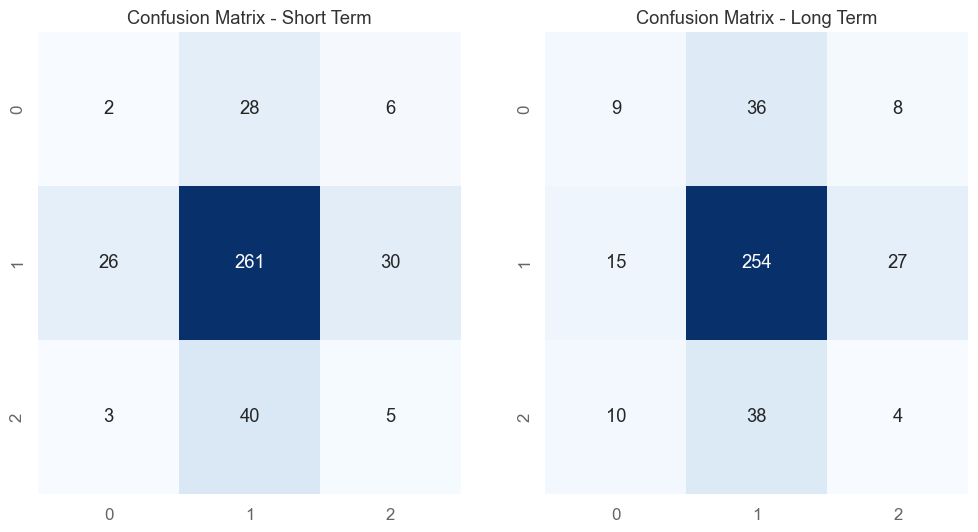

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get all predictions and true labels
y_true_short = []
y_pred_short = []
y_true_long = []
y_pred_long = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        X_batch, y_short_batch, y_long_batch = batch
        short_term_output, long_term_output = model(X_batch)
        _, predicted_short = torch.max(short_term_output.data, 1)
        _, predicted_long = torch.max(long_term_output.data, 1)
        
        y_true_short.extend(y_short_batch.numpy())
        y_pred_short.extend(predicted_short.numpy())
        y_true_long.extend(y_long_batch.numpy())
        y_pred_long.extend(predicted_long.numpy())

# Convert lists to numpy arrays
y_true_short = np.array(y_true_short)
y_pred_short = np.array(y_pred_short)
y_true_long = np.array(y_true_long)
y_pred_long = np.array(y_pred_long)

# Create confusion matrices
cm_short = confusion_matrix(y_true_short, y_pred_short)
cm_long = confusion_matrix(y_true_long, y_pred_long)

# Plot confusion matrices
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm_short, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Short Term')

plt.subplot(1, 2, 2)
sns.heatmap(cm_long, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Long Term')

plt.show()
